In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product 
import pandas as pd
from sklearn.cluster import KMeans
import os
import sudoku as sudo
%matplotlib qt

In [30]:
n = 81
eps = 0.01
time = 80000
space = np.zeros((n,int(time)))

# def H(x,strength,b=5):
#     return np.exp(b*strength)*x+ (np.exp(b*strength)-1)/(np.exp(b)-1)
# def H(x,strength,gamma=1,I=1.01):
#     tif = -1/gamma*np.log(1-(gamma/I))
#     return 1/tif * np.log(1/(np.exp(-tif*x)-(gamma/I)*strength))


def U(x,gamma=1,I=1.01):
    tif = -(1/gamma)*np.log(1-(gamma/I))
    return I/gamma*(1-np.exp(-tif*x))

def U_inv(x,gamma=1,I=1.01):
    tif = -(1/gamma)*np.log(1-(gamma/I))
    return -1/tif*np.log(1-(gamma/I)*x)

def H(x,strength,gamma=1,I=1.008):
    temp = np.clip(U(x,gamma=gamma,I=I)+strength,0,1)
    return U_inv(temp,gamma=gamma,I=I)


inh = np.load("sudoku.npy")
exi = 1-inh
np.fill_diagonal(exi,0.0)


In [33]:
%%time
sudoku = sudo.printSudoku(sudo.perfectSudoku())

#state = np.zeros(n)#np.random.normal(size=n)%1
#state[np.argsort(sudoku.flatten())] = np.repeat(np.linspace(0,1,10)[:-1],9)

state = np.random.normal(size=n)%1


for i in range(int(time)):
    
    #state -= 0.001*np.abs(np.random.normal(size=n))
    
    fire_time = np.min(1-state)   
    
    state = state + fire_time
    
    new_state = state + eps
    
    #m = 0
    while np.sum(new_state>=1)>0:
        #print(m,end="\r")
        #m+=1
        
        fire = new_state>=1
        
        new_state[fire] = 0.0
        
        coupling_exi = 0.0003*(np.matmul(exi,fire)>0)
        coupling_inh = 0.0006*np.matmul(inh,fire)
        
        total = coupling_exi-coupling_inh
        #print(total)
        
        state = new_state
        new_state = np.clip(H(state,total),a_min=0,a_max=None)
        
    state = new_state
    space[:,i] = state
    if i%1000 == 0:
        print('Progress',round(i/int(time)*100,1),"%",end="\r")

CPU times: user 5.98 s, sys: 71.2 ms, total: 6.05 s
Wall time: 6.01 s


In [34]:
df = pd.DataFrame(space[:,-1:])
model = KMeans(n_clusters=9)
pred = model.fit_predict(df)
order = np.argsort(pred)
fig = plt.figure(figsize=(15,10))
g = sns.heatmap(space[order,-100:],yticklabels=2,xticklabels=100,cmap='viridis')
#g = sns.heatmap(space[:,-100:],yticklabels=2,xticklabels=100,cmap='viridis')
g.set_yticklabels(fig.axes[0].get_yticklabels(),rotation=0)
print()

In [35]:
rs =100
phase = space[:,::rs]-space[0,::rs]
phase[phase<0] = 1+phase[phase<0]
#phase = np.min([np.abs(space[:,::rs]-space[0,::rs]),np.abs(1-space[:,::rs]+space[0,::rs]),np.abs(1+space[:,::rs]-space[0,::rs])],axis=0)


plt.figure()
cm = plt.cm.hsv(np.linspace(0.5,1,9))
for i in range(81):
    plt.plot(phase[i,:],'.',markersize=1,c=cm[pred[i]])
#plt.plot(np.linspace(0,500,10000),np.abs())
plt.show()

In [27]:
for i in range(9):
    temp = np.arange(0,81,1,dtype=np.int32)[pred==i]
    sum_ = 0
    for j,k in product(temp,temp):
        sum_ += inh[j,k]
    print(sum_)

10
14
26
0
0
20
0
0
6


In [364]:
from matplotlib.animation import FuncAnimation
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(10,10))
ax.set(xlim=(-1.5, 1.5), ylim=(-1.5, 1.5))

def phasetopos(phi):
    return np.cos(2*np.pi*phi), np.sin(2*np.pi*phi)

temp = phasetopos(space[:,0])
data = ax.plot(temp[0],temp[1],'o',alpha=0.5)[0]

def animate(i):
    temp = phasetopos(space[:,i])
    data.set_xdata(temp[0])
    data.set_ydata(temp[1])

anim = FuncAnimation(
    fig, animate, interval=100, frames=int(time/eps)-1,repeat=False)
 
plt.draw()
plt.show()

In [28]:
#sudoku
(pred+1).reshape((9,9))

array([[8, 2, 2, 6, 6, 3, 5, 1, 4],
       [1, 5, 6, 2, 4, 3, 3, 2, 2],
       [3, 4, 9, 1, 1, 5, 3, 6, 6],
       [6, 3, 3, 3, 9, 2, 1, 7, 5],
       [4, 9, 2, 5, 1, 2, 8, 3, 3],
       [5, 1, 1, 3, 6, 6, 2, 9, 9],
       [9, 1, 7, 9, 5, 1, 6, 3, 6],
       [3, 3, 6, 4, 2, 7, 9, 5, 8],
       [2, 6, 5, 6, 3, 8, 9, 4, 1]], dtype=int32)

In [362]:
def check_sudo(x):
    for i in range(9):
        if not np.array_equal(np.sort(x[:,i]),np.arange(1,10,dtype=np.int32)):
            print("column",i)
            return False
        if not np.array_equal(np.sort(x[i,:]),np.arange(1,10,dtype=np.int32)):
            print("row",i)
            return False
    for i,j in product(range(3),range(3)):    
        if not np.array_equal(np.sort(x[3*i:3*i+3,3*j:3*j+3].flatten()),np.arange(1,10,dtype=np.int32)):
            print(i,j)
            return False
    return True

In [363]:
check_sudo((pred+1).reshape((9,9)))

True

In [531]:
x=np.arange(0,1,0.01)
for I,c in zip([1.1,1.01,1.001,1.0001,1.00001],plt.cm.viridis(np.linspace(0,1,5))):
    plt.plot(x,U(x,I=I),label=r"$I=$"+str(I),color=c)
plt.legend()
plt.show()

In [530]:
x=np.arange(0,1,0.01)
for I,c in zip([1.1,1.01,1.001,1.0001,1.00001],plt.cm.viridis(np.linspace(0,1,5))):
    plt.plot(x,U_inv(x,I=I),label=r"$I=$"+str(I),color=c)
plt.legend()
plt.show()

In [546]:
x=np.arange(0,1,0.01)
for b,c in zip(np.linspace(-1,1,50),plt.cm.RdBu(np.linspace(0,1,50))):
    plt.plot(x,H(x,0.02*b),color=c)
plt.show()

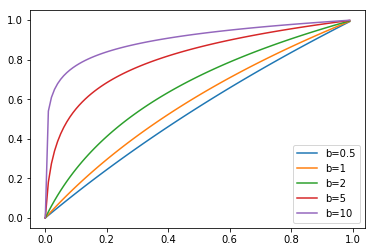

In [68]:
x=np.arange(0,1,0.01)
for b in [0.5,1,2,5,10]:
    plt.plot(x,1/b*np.log(1+(np.exp(b)-1)*x),label='b='+str(b))
plt.legend()
plt.show()

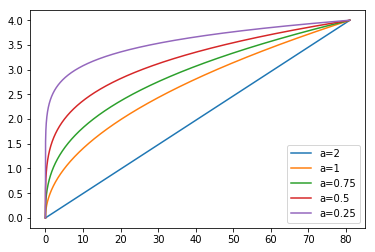

In [16]:
x=np.arange(0,81,0.01)
for a in [2,1,0.75,0.5,0.25]:
    plt.plot(x,kernel(x,a=a),label='a='+str(a))
plt.legend()
plt.show()

In [425]:
plt.figure(figsize=(15,5))
order = np.argsort(space[:,-1])
sns.heatmap(space[order,-1000:],yticklabels=9,xticklabels=100,cmap='viridis')
#sns.heatmap(space[:,-2000:],xticklabels=100,cmap='viridis')
#plt.imshow(space[:,-200:])